In [1]:
import numpy as np
import cupy as cp

import poppy
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

from scoobpsf import scoobm, agpm
reload(scoobm)

import lina
xp = lina.math_module.xp
from lina.imshows import imshow1, imshow2, imshow3

# import misc_funs as misc

poppy_log.disabled = True

pupil_diam = 6.75*u.mm
wavelength_c = 632.8e-9*u.m

dm_flat = fits.getdata(scoobm.module_path/'scoob_dm_flat.fits')

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, rotation=20)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3.6*u.mm/2, gray_pixel=False)




Could not import scoobpy. Testbed interface unavailable.


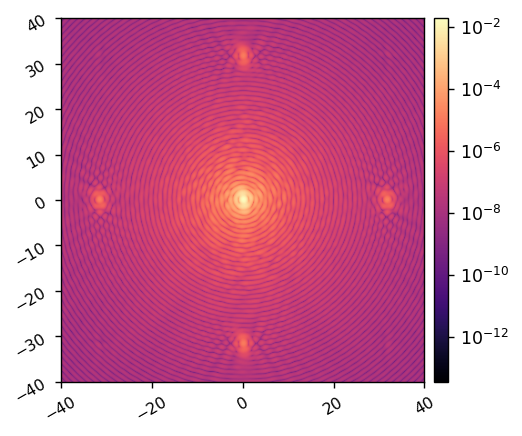

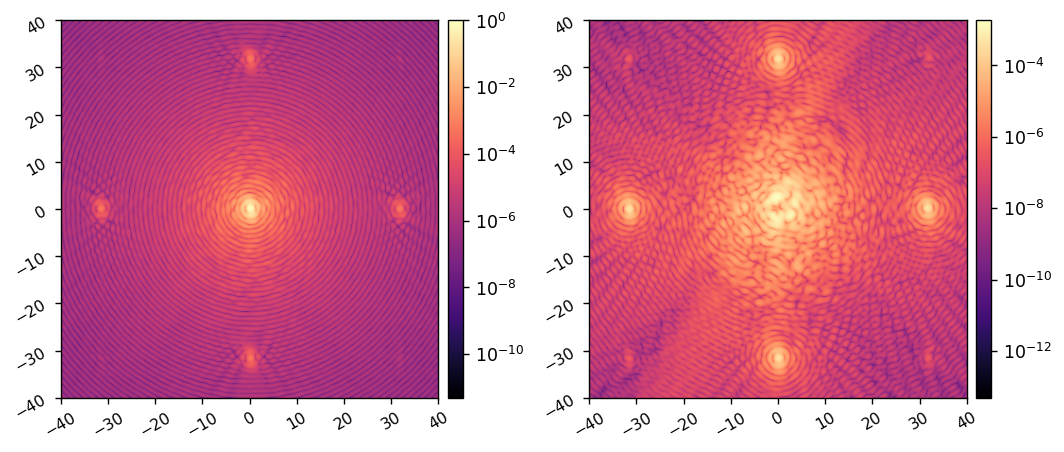

In [2]:
reload(scoobm)
model = scoobm.SCOOBM()
model.npix = 512
model.oversample = 4
model.det_rotation = 0
model.set_dm(dm_flat)

ref_im = model.snap(True)

model.imnorm = ref_im.max()
normalized_im = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

occ_im = model.snap()
imshow2(normalized_im, occ_im, lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

Nact = model.Nact
npsf = model.npsf
psf_pixelscale_lamD = model.psf_pixelscale_lamD

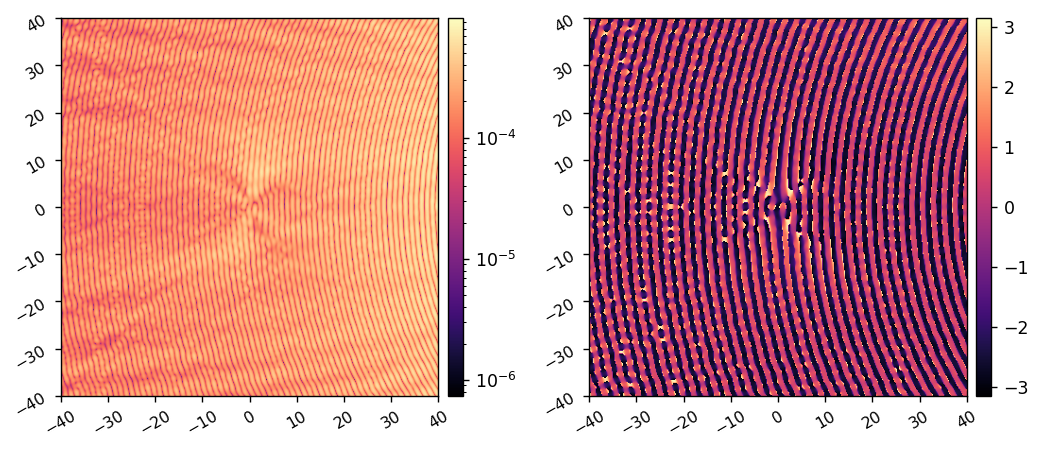

In [3]:
model.source_offset = (100,0)
im = model.calc_psf(True)

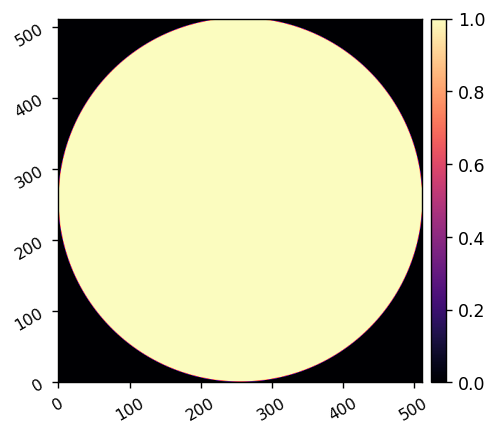

16


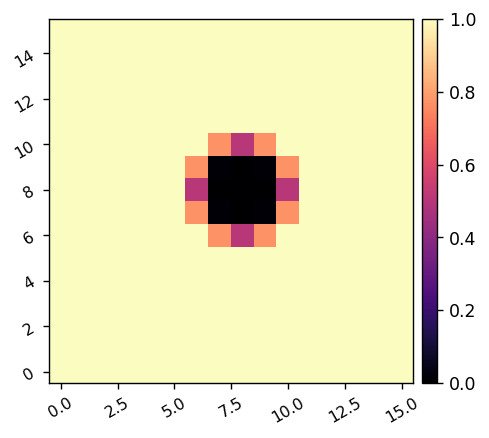

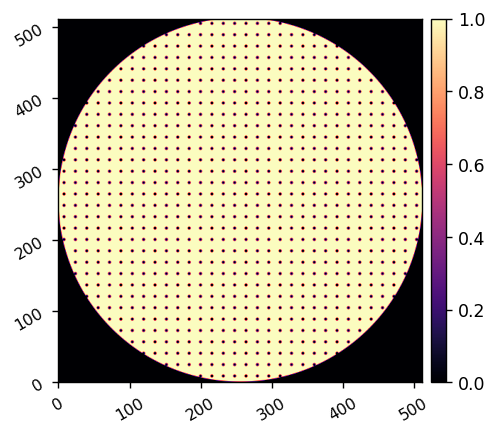

In [8]:
reload(lina.utils)
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=model.npix, oversample=1)
ap = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(wf)
imshow1(ap)

grating_period = pupil_diam.to(u.m)/34
grating_period_pix = grating_period.to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
grating_period_pix = round(grating_period_pix/2)*2
print(grating_period_pix)
# grating_period = 20 # in pixels

gwf = poppy.FresnelWavefront(beam_radius=grating_period, npix=grating_period_pix, oversample=1)
grating_obs = poppy.InverseTransmission(poppy.CircularAperture(radius=50*u.um)).get_transmission(gwf)
imshow1(grating_obs)

nobs = model.npix//grating_period_pix

grating = lina.utils.pad_or_crop(xp.tile(grating_obs, (nobs,nobs)), model.npix)*ap
imshow1(grating)

G = poppy.ArrayOpticalElement(transmission=grating, pixelscale=wf.pixelscale)

In [11]:
model.npsf

400

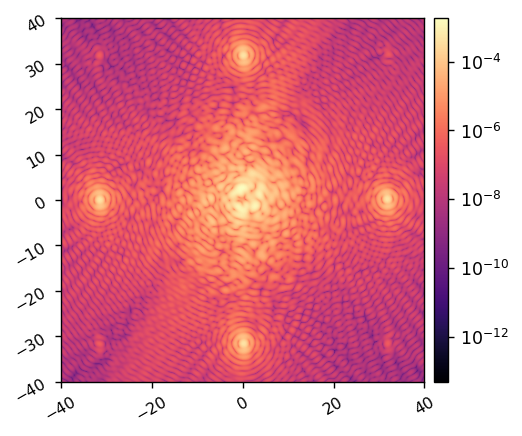

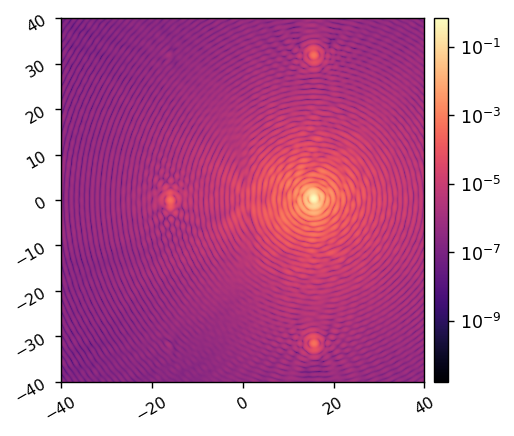

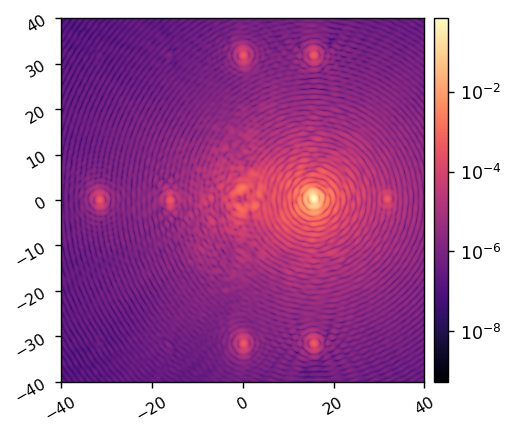

In [19]:
model.OPD = None
# model.OPD = G
model.npsf = 400
model.source_offset = (0,0)
im_on = model.snap(True)

model.source_offset = (15,0)
im_off = model.snap(True)

im = im_on + im_off
imshow1(im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

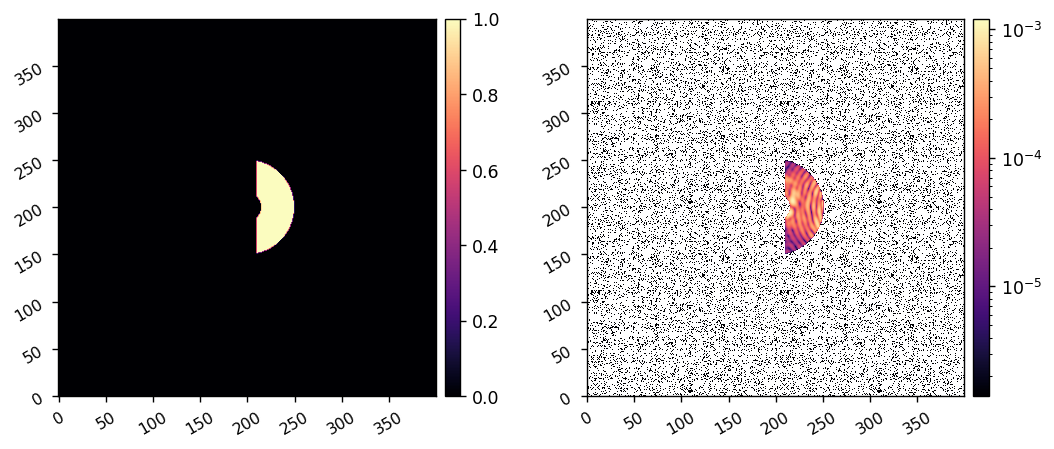

In [20]:
reload(lina.utils)
npsf = model.npsf
Nact = model.Nact

xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*model.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 10
rot = 0

# Create the mask that is used to select which region to make dark.
dark_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge' : edge,
    'rotation':rot,
}
dark_mask = lina.utils.create_annular_focal_plane_mask(fpx, fpy, dark_params)
imshow2(dark_mask, dark_mask*im, lognorm2=True)

In [22]:
reload(lina)

<module 'lina' from 'c:\\users\\kian\\projects\\lina\\lina\\__init__.py'>

In [25]:
reload(lina.bsefc)

model.set_dm(dm_flat)
epsilon = 1e-9 # poke amplitudes (DM surface)
jac = lina.bsefc.build_jacobian(model, epsilon, dark_mask.flatten(), 
                                bs_offset=(15,0),
                                plot=False)

	Calculated response for mode 1/952. Elapsed time=1.236 sec.
	Calculated response for mode 2/952. Elapsed time=2.297 sec.
	Calculated response for mode 3/952. Elapsed time=3.351 sec.
	Calculated response for mode 4/952. Elapsed time=4.455 sec.
	Calculated response for mode 5/952. Elapsed time=5.495 sec.
	Calculated response for mode 6/952. Elapsed time=6.545 sec.
	Calculated response for mode 7/952. Elapsed time=7.586 sec.
	Calculated response for mode 8/952. Elapsed time=8.636 sec.
	Calculated response for mode 9/952. Elapsed time=9.691 sec.
	Calculated response for mode 10/952. Elapsed time=10.749 sec.
	Calculated response for mode 11/952. Elapsed time=11.805 sec.
	Calculated response for mode 12/952. Elapsed time=12.918 sec.
	Calculated response for mode 13/952. Elapsed time=14.070 sec.
	Calculated response for mode 14/952. Elapsed time=15.156 sec.
	Calculated response for mode 15/952. Elapsed time=16.203 sec.
	Calculated response for mode 16/952. Elapsed time=17.276 sec.
	Calculate

	Calculated response for mode 131/952. Elapsed time=138.794 sec.
	Calculated response for mode 132/952. Elapsed time=139.839 sec.
	Calculated response for mode 133/952. Elapsed time=140.893 sec.
	Calculated response for mode 134/952. Elapsed time=141.940 sec.
	Calculated response for mode 135/952. Elapsed time=143.000 sec.
	Calculated response for mode 136/952. Elapsed time=144.055 sec.
	Calculated response for mode 137/952. Elapsed time=145.117 sec.
	Calculated response for mode 138/952. Elapsed time=146.169 sec.
	Calculated response for mode 139/952. Elapsed time=147.229 sec.
	Calculated response for mode 140/952. Elapsed time=148.277 sec.
	Calculated response for mode 141/952. Elapsed time=149.335 sec.
	Calculated response for mode 142/952. Elapsed time=150.384 sec.
	Calculated response for mode 143/952. Elapsed time=151.435 sec.
	Calculated response for mode 144/952. Elapsed time=152.496 sec.
	Calculated response for mode 145/952. Elapsed time=153.555 sec.
	Calculated response for 

	Calculated response for mode 258/952. Elapsed time=272.719 sec.
	Calculated response for mode 259/952. Elapsed time=273.766 sec.
	Calculated response for mode 260/952. Elapsed time=274.816 sec.
	Calculated response for mode 261/952. Elapsed time=275.867 sec.
	Calculated response for mode 262/952. Elapsed time=276.920 sec.
	Calculated response for mode 263/952. Elapsed time=277.978 sec.
	Calculated response for mode 264/952. Elapsed time=279.035 sec.
	Calculated response for mode 265/952. Elapsed time=280.091 sec.
	Calculated response for mode 266/952. Elapsed time=281.135 sec.
	Calculated response for mode 267/952. Elapsed time=282.187 sec.
	Calculated response for mode 268/952. Elapsed time=283.235 sec.
	Calculated response for mode 269/952. Elapsed time=284.285 sec.
	Calculated response for mode 270/952. Elapsed time=285.325 sec.
	Calculated response for mode 271/952. Elapsed time=286.365 sec.
	Calculated response for mode 272/952. Elapsed time=287.405 sec.
	Calculated response for 

	Calculated response for mode 385/952. Elapsed time=405.644 sec.
	Calculated response for mode 386/952. Elapsed time=406.693 sec.
	Calculated response for mode 387/952. Elapsed time=407.728 sec.
	Calculated response for mode 388/952. Elapsed time=408.780 sec.
	Calculated response for mode 389/952. Elapsed time=409.824 sec.
	Calculated response for mode 390/952. Elapsed time=410.895 sec.
	Calculated response for mode 391/952. Elapsed time=411.955 sec.
	Calculated response for mode 392/952. Elapsed time=413.020 sec.
	Calculated response for mode 393/952. Elapsed time=414.065 sec.
	Calculated response for mode 394/952. Elapsed time=415.112 sec.
	Calculated response for mode 395/952. Elapsed time=416.165 sec.
	Calculated response for mode 396/952. Elapsed time=417.198 sec.
	Calculated response for mode 397/952. Elapsed time=418.245 sec.
	Calculated response for mode 398/952. Elapsed time=419.289 sec.
	Calculated response for mode 399/952. Elapsed time=420.355 sec.
	Calculated response for 

	Calculated response for mode 512/952. Elapsed time=538.934 sec.
	Calculated response for mode 513/952. Elapsed time=539.988 sec.
	Calculated response for mode 514/952. Elapsed time=541.054 sec.
	Calculated response for mode 515/952. Elapsed time=542.119 sec.
	Calculated response for mode 516/952. Elapsed time=543.176 sec.
	Calculated response for mode 517/952. Elapsed time=544.235 sec.
	Calculated response for mode 518/952. Elapsed time=545.292 sec.
	Calculated response for mode 519/952. Elapsed time=546.345 sec.
	Calculated response for mode 520/952. Elapsed time=547.400 sec.
	Calculated response for mode 521/952. Elapsed time=548.448 sec.
	Calculated response for mode 522/952. Elapsed time=549.495 sec.
	Calculated response for mode 523/952. Elapsed time=550.549 sec.
	Calculated response for mode 524/952. Elapsed time=551.614 sec.
	Calculated response for mode 525/952. Elapsed time=552.650 sec.
	Calculated response for mode 526/952. Elapsed time=553.707 sec.
	Calculated response for 

	Calculated response for mode 639/952. Elapsed time=672.619 sec.
	Calculated response for mode 640/952. Elapsed time=673.674 sec.
	Calculated response for mode 641/952. Elapsed time=674.714 sec.
	Calculated response for mode 642/952. Elapsed time=675.759 sec.
	Calculated response for mode 643/952. Elapsed time=676.804 sec.
	Calculated response for mode 644/952. Elapsed time=677.854 sec.
	Calculated response for mode 645/952. Elapsed time=678.901 sec.
	Calculated response for mode 646/952. Elapsed time=679.954 sec.
	Calculated response for mode 647/952. Elapsed time=680.996 sec.
	Calculated response for mode 648/952. Elapsed time=682.055 sec.
	Calculated response for mode 649/952. Elapsed time=683.104 sec.
	Calculated response for mode 650/952. Elapsed time=684.155 sec.
	Calculated response for mode 651/952. Elapsed time=685.209 sec.
	Calculated response for mode 652/952. Elapsed time=686.254 sec.
	Calculated response for mode 653/952. Elapsed time=687.309 sec.
	Calculated response for 

	Calculated response for mode 766/952. Elapsed time=807.837 sec.
	Calculated response for mode 767/952. Elapsed time=808.994 sec.
	Calculated response for mode 768/952. Elapsed time=810.043 sec.
	Calculated response for mode 769/952. Elapsed time=811.118 sec.
	Calculated response for mode 770/952. Elapsed time=812.182 sec.
	Calculated response for mode 771/952. Elapsed time=813.240 sec.
	Calculated response for mode 772/952. Elapsed time=814.353 sec.
	Calculated response for mode 773/952. Elapsed time=815.416 sec.
	Calculated response for mode 774/952. Elapsed time=816.517 sec.
	Calculated response for mode 775/952. Elapsed time=817.568 sec.
	Calculated response for mode 776/952. Elapsed time=818.615 sec.
	Calculated response for mode 777/952. Elapsed time=819.665 sec.
	Calculated response for mode 778/952. Elapsed time=820.715 sec.
	Calculated response for mode 779/952. Elapsed time=821.772 sec.
	Calculated response for mode 780/952. Elapsed time=822.834 sec.
	Calculated response for 

	Calculated response for mode 893/952. Elapsed time=943.894 sec.
	Calculated response for mode 894/952. Elapsed time=944.977 sec.
	Calculated response for mode 895/952. Elapsed time=946.043 sec.
	Calculated response for mode 896/952. Elapsed time=947.160 sec.
	Calculated response for mode 897/952. Elapsed time=948.270 sec.
	Calculated response for mode 898/952. Elapsed time=949.348 sec.
	Calculated response for mode 899/952. Elapsed time=950.447 sec.
	Calculated response for mode 900/952. Elapsed time=951.683 sec.
	Calculated response for mode 901/952. Elapsed time=952.764 sec.
	Calculated response for mode 902/952. Elapsed time=953.819 sec.
	Calculated response for mode 903/952. Elapsed time=954.883 sec.
	Calculated response for mode 904/952. Elapsed time=955.943 sec.
	Calculated response for mode 905/952. Elapsed time=957.015 sec.
	Calculated response for mode 906/952. Elapsed time=958.085 sec.
	Calculated response for mode 907/952. Elapsed time=959.153 sec.
	Calculated response for 

In [26]:
import misc_funs as misc
misc.save_fits('bsjac.fits', lina.utils.ensure_np_array(jac))

Saved data to:  bsjac.fits


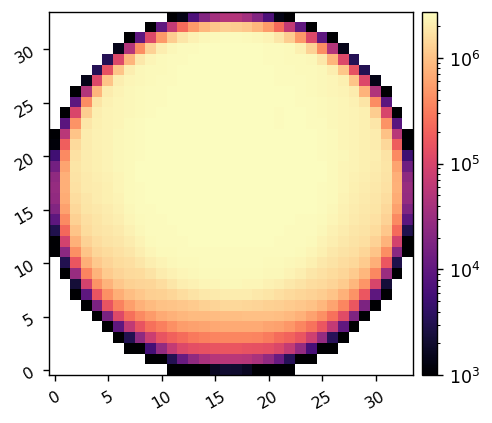

In [27]:
reload(lina.utils)
response = lina.utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)).get(), model.dm_mask)
imshow1(response, lognorm=True, vmin=1e3)

In [28]:
jac.shape

(11424, 952)

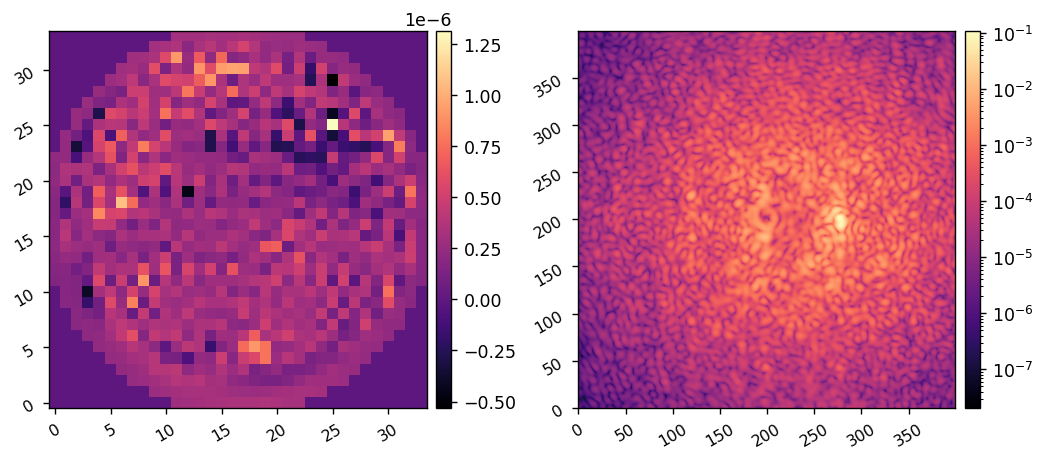

EFC interrupted.
EFC completed in 10.490 sec.


C:\Users\Kian\anaconda3\envs\poppy-env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Kian\anaconda3\envs\poppy-env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
reload(lina.bsefc)
reload(lina.utils)
model.set_dm(dm_flat)

bs_offset = (15,0)
reg_conds = [(-1, 10), (-2,10), (-3,5), (-2,20)]

for i in range(len(reg_conds)):
    control_matrix = lina.utils.beta_reg(jac, reg_conds[i][0])
    
    ims, commands = lina.bsefc.run_efc_perfect(model, bs_offset,
                                            jac, 
                                            control_matrix,
                                            dark_mask, 
                                            Imax_unocc=1,
                                            efc_loop_gain=0.5, 
                                            iterations=reg_conds[i][1], 
#                                             plot_all=True, 
                                            plot_sms=True,
                                             plot_radial_contrast=True)